In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# FILE = '/content/drive/MyDrive/msis_sem1_project/dga_4k.csv'
FILE = '/content/drive/MyDrive/Colab Notebooks/mini_project/dga_multi.csv'
df = pd.read_csv(FILE)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df.head()

,Domain,Botnet_Family
0,rdaudaep.com,szribi
1,msemzrvzglrzbuuseik.biz,qakbot
2,pbobadmvxxh.com,ramnit
3,qgiykqweseuukuiw.org,ramdo
4,ixjcbhjxex.mooo.com,kraken


**DATA PREP**

In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

In [5]:
tokenizer = Tokenizer(char_level=True)  # char_level=True treats each character as a token
tokenizer.fit_on_texts(df['Domain'])

sequences = tokenizer.texts_to_sequences(df['Domain'])

X = pad_sequences(sequences, maxlen=50, padding='post')

In [ ]:
len(tokenizer.word_index)

42

In [6]:
label_encoder = LabelEncoder()
df['Botnet_Family'] = label_encoder.fit_transform(df['Botnet_Family'])

y = to_categorical(df['Botnet_Family'])

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

**MODELLING**

In [11]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Dropout, Dense, Flatten, MultiHeadAttention, LayerNormalization, Add
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Input layer
input_seq = Input(shape=(50,))

# Embedding layer
embedded = Embedding(input_dim=43, output_dim=192)(input_seq)

# Convolutional layers
conv1 = Conv1D(filters=256, kernel_size=7, activation='relu')(embedded)
pool1 = MaxPooling1D(pool_size=2)(conv1)

conv2 = Conv1D(filters=128, kernel_size=5, activation='relu')(pool1)
pool2 = MaxPooling1D(pool_size=2)(conv2)

# Multi-Head Self-Attention layer
attention_output = MultiHeadAttention(num_heads=4, key_dim=128)(pool2, pool2)
attention_output = Add()([attention_output, pool2])  # Residual connection
attention_output = LayerNormalization()(attention_output)  # Normalization

# Flatten and output layers
flatten = Flatten()(attention_output)
dense1 = Dense(128, activation='relu')(flatten)
dropout = Dropout(0.25)(dense1)
output = Dense(60, activation='softmax')(dropout)

# Create model
model = Model(inputs=input_seq, outputs=output)

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

# Train the model with early stopping
history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=0.2, callbacks=[early_stopping, reduce_lr])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Epoch 1/100
12000/12000 ━━━━━━━━━━━━━━━━━━━━ 54s 4ms/step - accuracy: 0.6495 - loss: 1.2118 - val_accuracy: 0.8185 - val_loss: 0.5106 - learning_rate: 0.0010
Epoch 2/100
12000/12000 ━━━━━━━━━━━━━━━━━━━━ 74s 4ms/step - accuracy: 0.8241 - loss: 0.5030 - val_accuracy: 0.8399 - val_loss: 0.4421 - learning_rate: 0.0010
Epoch 3/100
12000/12000 ━━━━━━━━━━━━━━━━━━━━ 43s 4ms/step - accuracy: 0.8403 - loss: 0.4487 - val_accuracy: 0.8446 - val_loss: 0.4222 - learning_rate: 0.0010
Epoch 4/100
12000/12000 ━━━━━━━━━━━━━━━━━━━━ 43s 4ms/step - accuracy: 0.8472 - loss: 0.4234 - val_accuracy: 0.8531 - val_loss: 0.4014 - learning_rate: 0.0010
Epoch 5/100
12000/12000 ━━━━━━━━━━━━━━━━━━━━ 82s 4ms/step - accuracy: 0.8541 - loss: 0.4000 - val_accuracy: 0.8534 - val_loss: 0.4118 - learning_rate: 0.0010
Epoch 6/100
12000/12000 ━━━━━━━━━━━━━━━━━━━━ 82s 4ms/step - accuracy: 0.8591 - loss: 0.3918 - val_accuracy: 0.8567 - val_loss: 0.4015 - learning_rate: 0.0010
Epoch 7/100
12000/12000 ━━━━━━━━━━━━━━━━━━━━ 86s 4ms

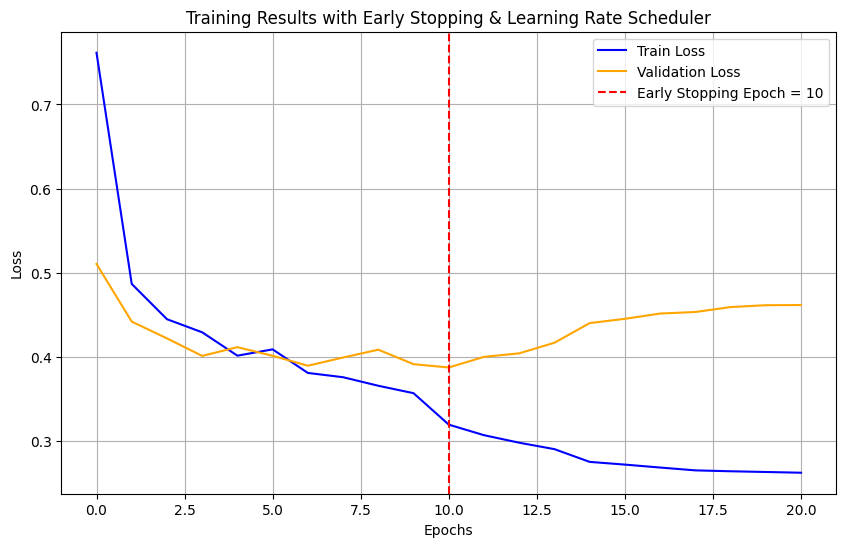

In [14]:
import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Train Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='orange')

early_stop_epoch = early_stopping.stopped_epoch - 10
if early_stop_epoch > 0:
    plt.axvline(x=early_stop_epoch, color='red', linestyle='--', label=f'Early Stopping Epoch = {early_stop_epoch}')

plt.title('Training Results with Early Stopping & Learning Rate Scheduler')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 50)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 50, 192)        │          8,256 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_2 (Conv1D)         │ (None, 44, 256)        │        344,320 │ embedding_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_2           │ (None, 22, 256)        │              0 │ conv1d_2[0][0]         │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_3 (Conv1D)         │ (None, 18, 128)        │        163,968 │ max_pooling1d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_3           │ (None, 9, 128)         │              0 │ conv1d_3[0][0]         │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 9, 128)         │        263,808 │ max_pooling1d_3[0][0], │
│ (MultiHeadAttention)      │                        │                │ max_pooling1d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 9, 128)         │              0 │ multi_head_attention_… │
│                           │                        │                │ max_pooling1d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 9, 128)         │            256 │ add_1[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 1152)           │              0 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 128)            │        147,584 │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 128)            │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 60)             │          7,740 │ dropout_2[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,807,798 (10.71 MB)

 Trainable params: 935,932 (3.57 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,871,866 (7.14 MB)

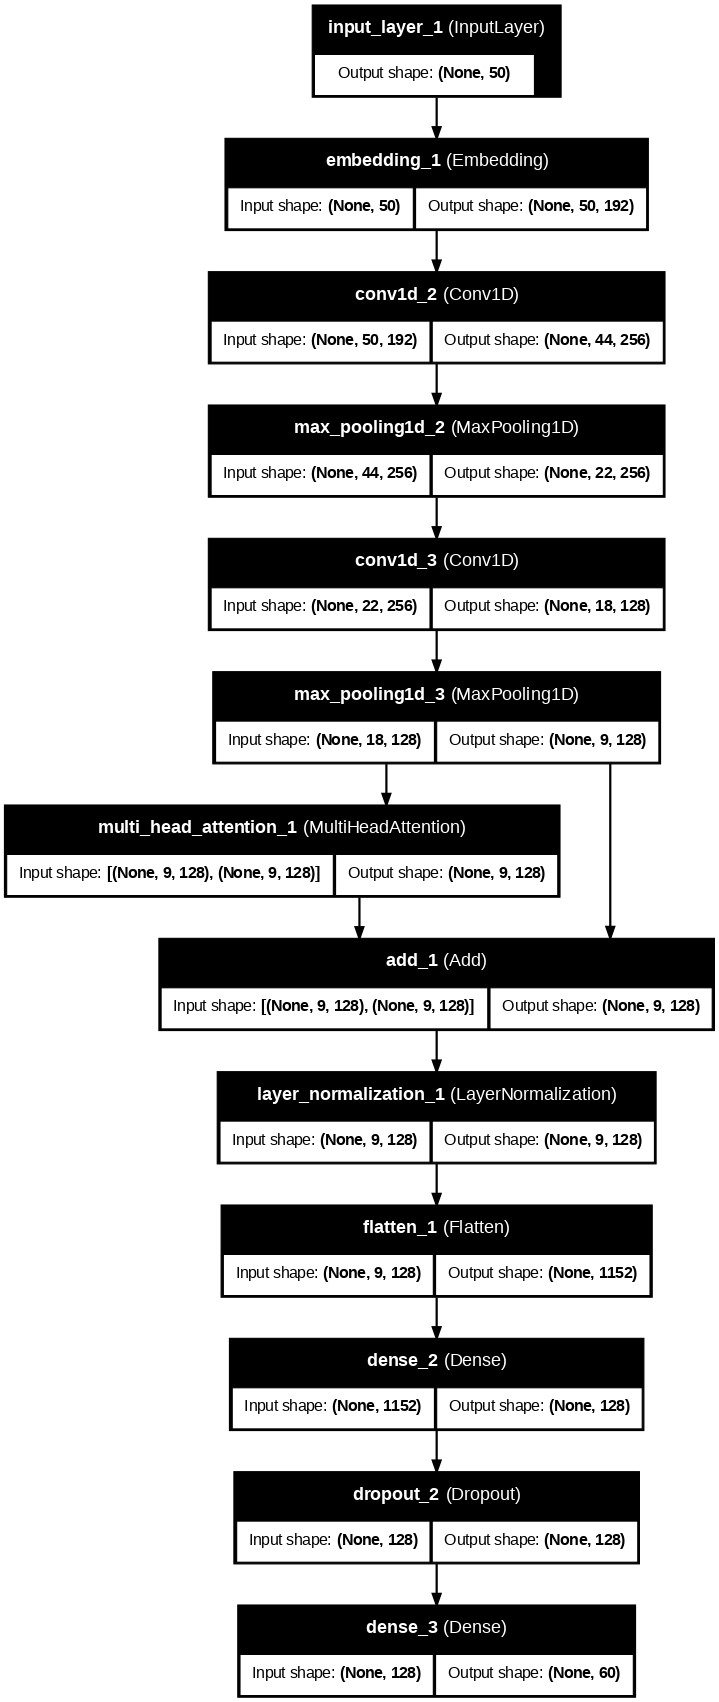

In [16]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model_plot.png', dpi=80, rankdir='TB')

In [ ]:
'''import joblib

joblib.dump(tokenizer, 'tokenizer.pkl')
joblib.dump(label_encoder, 'encoder_multi.pkl')
joblib.dump(model1, 'multiclass_classification_model.pkl')'''

"import joblib\n\njoblib.dump(tokenizer, 'tokenizer.pkl')\njoblib.dump(label_encoder, 'encoder_multi.pkl')\njoblib.dump(model1, 'multiclass_classification_model.pkl')"